Скачиваем датасет с отзывами на фильмы

In [ ]:
!wget http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz

--2024-03-01 08:00:34--  http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3127238 (3.0M) [application/x-gzip]
Saving to: ‘review_polarity.tar.gz’

review_polarity.tar 100%[===================>]   2.98M  11.8MB/s    in 0.3s    

2024-03-01 08:00:35 (11.8 MB/s) - ‘review_polarity.tar.gz’ saved [3127238/3127238]



Разархивируем датасет

In [ ]:
!tar -xf review_polarity.tar.gz

Подгружаем модуль для загрузки датасете и загружаем его

In [ ]:
import sklearn
from sklearn.datasets import load_files

In [ ]:
datadir="txt_sentoken"
movie_review_data=load_files(datadir,shuffle=True)

In [ ]:
movie_review_data.target

array([0, 1, 1, ..., 1, 0, 0])

In [ ]:
movie_review_data.target_names

['neg', 'pos']

Конвертируем загруженный датасет в формат датафрейма pandas

In [ ]:
import pandas as pd
df = pd.DataFrame(data=movie_review_data.data)
df["target"] = movie_review_data.target

In [ ]:
df.head()

,0,target
0,"b""arnold schwarzenegger has been an icon for a...",0
1,"b""good films are hard to find these days . \ng...",1
2,"b""quaid stars as a man who has taken up the pr...",1
3,b'we could paraphrase michelle pfieffer\'s cha...,0
4,"b""kolya is one of the richest films i've seen ...",1


In [ ]:
df = df.rename(columns={0: 'Review'})

In [ ]:
df["target"].value_counts()

0    1000
1    1000
Name: target, dtype: int64

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def clean(review):
  review = review.decode().lower()
  review = re.sub('[^a-z A-Z 0-9-]+', '', review)
  review = " ".join([word for word in review.split() if word not in stopwords.words('english')])
  return review


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['Review_cleaned'] = df['Review'].apply(clean)

Создаем пайплайн из двух элементов: создание векторов на основе tfidf и линейный SVM. Затем определяем гиперпараметры для поиска лучших. И запускаем gridsearch для перебора вариантов и нахождения оптимального.

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y = df['target']
X = df['Review_cleaned'].values

from sklearn.pipeline import Pipeline
pipeline = Pipeline(
    [
        ("tfidf_vect", TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None, use_idf=True, norm=None)),
        ("clf", LinearSVC()),
    ]
)

parameters = {
    'tfidf_vect__ngram_range': [(1,1),(1,2),(2,2)],
    'clf__C': [0.1, 1, 10, 100, 1000],
    'clf__random_state': [2023],
}

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023, test_size=0.2)
grid = GridSearchCV(estimator=pipeline, param_grid=parameters, verbose = 3, n_jobs=6)

grid.fit(X_train, y_train)
best_parameters = grid.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

y_pred_optimized = grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_optimized))


Fitting 5 folds for each of 15 candidates, totalling 75 fits
clf__C: 0.1
clf__random_state: 2023
tfidf_vect__ngram_range: (1, 2)
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       215
           1       0.81      0.85      0.83       185

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400



Подбор гиперпараметров подобрал значение регуляризации 0.1, и число слов для tfidf 1 и 2.

Создаем пайплайн с оптимальными гиперпараметрами. Проводим кросс-валидацию для 5 fold.

In [ ]:
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import uniform, randint

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
pipeline = Pipeline(
    [
        ("tfidf_vect", TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None, use_idf=True, norm=None, ngram_range=(1,2))),
        ("clf", LinearSVC(C=0.1)),
    ]
)
for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
print(scores)

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       190
           1       0.87      0.83      0.85       210

    accuracy                           0.84       400
   macro avg       0.84      0.85      0.84       400
weighted avg       0.85      0.84      0.85       400

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       205
           1       0.86      0.85      0.85       195

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       204
           1       0.85      0.86      0.85       196

    accuracy                           0.85       400
   macro avg       0.85      0.86      0.85       400
weighted avg       0.86      0.85      0.86       400

              preci

Интерпретация найденных гиперпараметров. Найденное С со значеним 0.1 означает, что значение регуляризация мало и гиперплоскость разделяющая объекты имеет вид прямой. Меньшее значение имеет лучшую предсказательную силу. ngram 1,2 говорит о том, что лучше всего показывают себя последовательности из 1 и 2 слов (unigram, bigram)

In [ ]:
from matplotlib import pyplot as plt

def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()


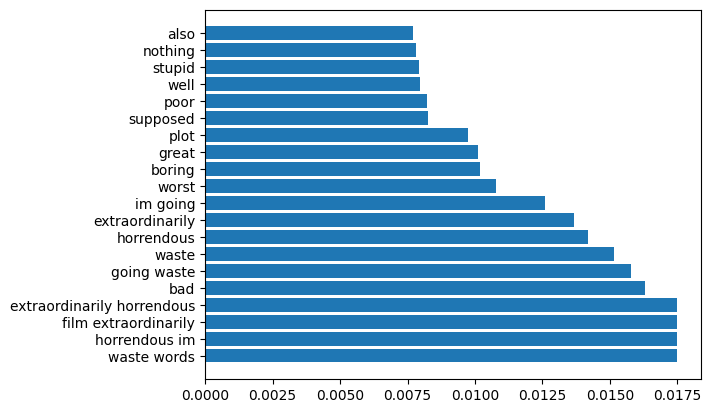

In [ ]:
f_importances(abs(pipeline[1].coef_[0]), pipeline[0].get_feature_names_out(), top=20)

Коэффициенты SVM показаны на графике. Наибольшей важностью обладают слова waste words, horrendous im, film extraordinarily, extraordinarily horrendous.